In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from fitter import Fitter, get_common_distributions

# Channel Discharge vs Width Analysis

In [2]:
tauraat = pd.read_csv('./data/tau_pos_dis.csv', converters={'site_no': str}, low_memory=False)

In [5]:
tau_pos_freq = tauraat['site_no'].value_counts()

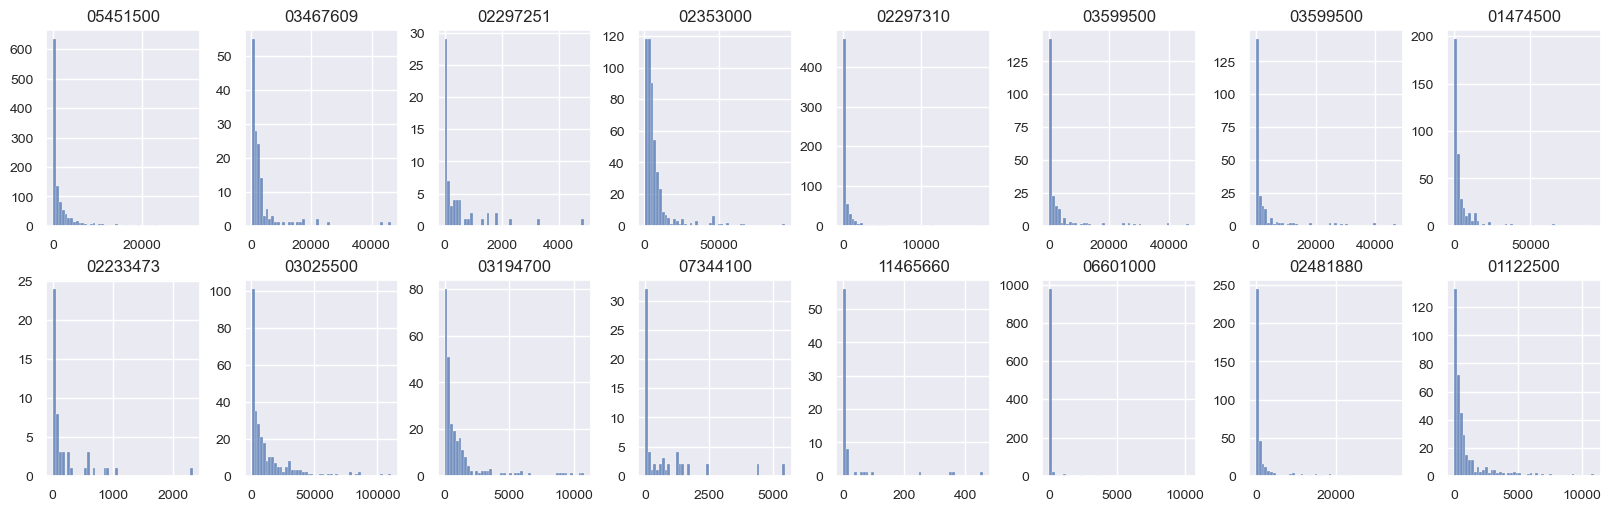

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=8 , figsize=(16, 5), constrained_layout=True)

random_sites = np.random.randint(0, 7098, 16).tolist()
for idx, site_obs in enumerate(tau_pos_freq.iloc[random_sites]):
    usgs_cd = tau_pos_freq.index[tau_pos_freq == site_obs].values[0]
    usgs_nm = tauraat[tauraat['site_no'] == usgs_cd].iloc[0]['station_nm']
    usgs_tp = tauraat[tauraat['site_no'] == usgs_cd].iloc[0]['site_tp_cd']

    i, j = divmod(idx, 8)
    df_plt = tauraat[tauraat["site_no"] == usgs_cd]

    # sns.histplot(x=df_plt['chan_width'], bins=50, ax=axes[i, j])
    sns.histplot(x=df_plt['discharge_va'], bins=50, ax=axes[i, j])
    axes[i, j].set_title(f"{usgs_cd}")
    axes[i, j].set_xlabel('')
    axes[i, j].tick_params(axis='x', labelsize=10)
    axes[i, j].set_ylabel('')
    axes[i, j].tick_params(axis='y', labelsize=10)

plt.savefig('./data/tau_discharge_dist.png')
# plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

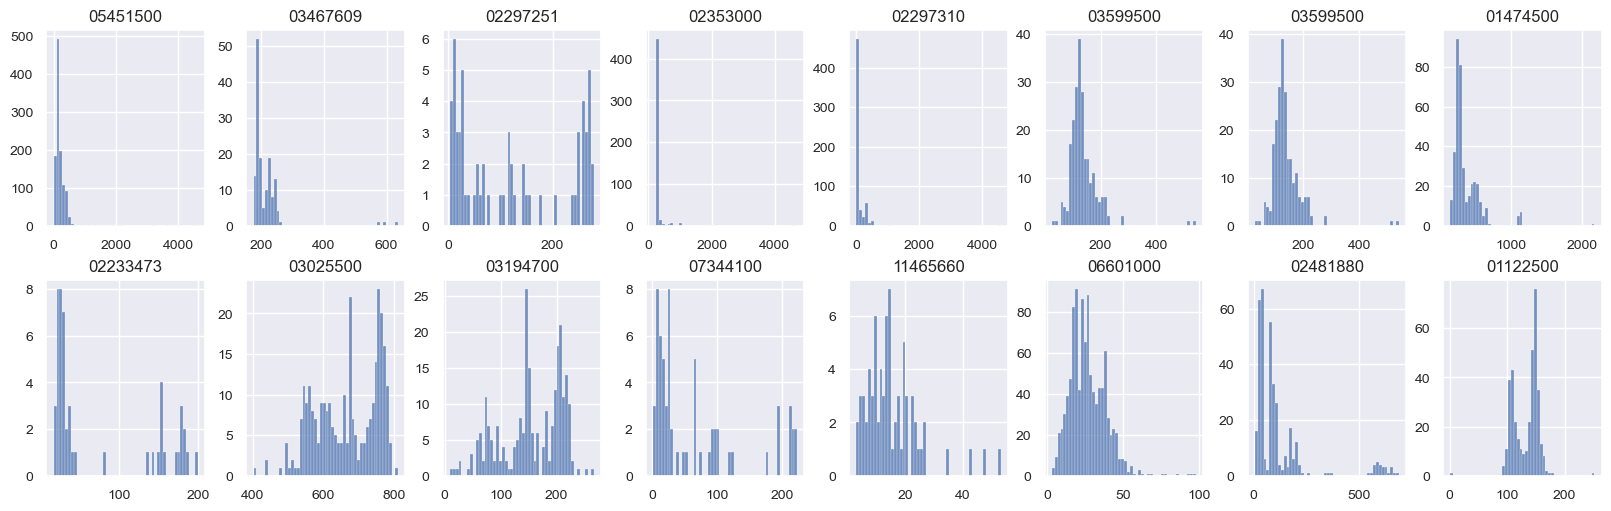

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=8 , figsize=(16, 5), constrained_layout=True)

for idx, site_obs in enumerate(tau_pos_freq.iloc[random_sites]):
    usgs_cd = tau_pos_freq.index[tau_pos_freq == site_obs].values[0]
    usgs_nm = tauraat[tauraat['site_no'] == usgs_cd].iloc[0]['station_nm']
    usgs_tp = tauraat[tauraat['site_no'] == usgs_cd].iloc[0]['site_tp_cd']

    i, j = divmod(idx, 8)
    df_plt = tauraat[tauraat["site_no"] == usgs_cd]

    sns.histplot(x=df_plt['chan_width'], bins=50, ax=axes[i, j])
    # sns.histplot(x=df_plt['discharge_va'], bins=50, ax=axes[i, j])
    axes[i, j].set_title(f"{usgs_cd}")
    axes[i, j].set_xlabel('')
    axes[i, j].tick_params(axis='x', labelsize=10)
    axes[i, j].set_ylabel('')
    axes[i, j].tick_params(axis='y', labelsize=10)

plt.savefig('./data/tau_width_dist.png')
# plt.subplots_adjust(hspace=0.3) # (left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

## Find the Best Distribution for Discharge

In [ ]:
best_fit_lst = []
for idx, (site, group) in enumerate(tauraat.groupby('site_no')):

    f = Fitter(group['discharge_va'].values, distributions= get_common_distributions())
    print(idx, site, f.fit())
    # f.summary(); break
    best_fit_dict = f.get_best(method='sumsquare_error')
    best_fit_lst.append([site, best_fit_dict])

In [37]:
with open('./data/fit_dist_discharge.txt', 'w') as fp:
    for item in best_fit_lst:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


In [38]:
best_fit_names = [list(item.keys())[0] for item in best_fit_lst]
df = pd.DataFrame({'freq': best_fit_names})
df = df.groupby('freq', as_index=False).size()
df

,freq,size
0,cauchy,2247
1,chi2,150
2,expon,395
3,exponpow,110
4,gamma,381
5,lognorm,3679
6,norm,48
7,powerlaw,37
8,rayleigh,45
9,uniform,6


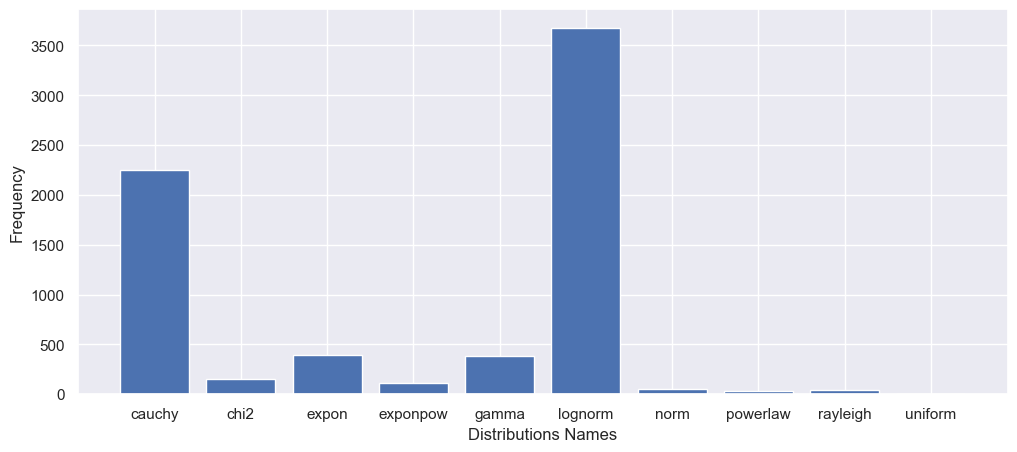

In [40]:
fig, ax = plt.subplots(figsize=(12,5))

ax.bar(df['freq'], df['size'])
ax.set_xlabel('Distributions Names')
ax.set_ylabel('Frequency')

plt.savefig('./data/dist_freq_discharge.png')
plt.show()

## Analysis Site Stations with Multi-modal Channel Width Distribution

### Utils

In [10]:
def site_extraction(site_no, dataset=tauraat, save_csv=False):
    subset = dataset[dataset["site_no"] == site_no]
    if save_csv:
        subset.to_csv(f"./data/{site_no}.csv", sep=',', encoding='utf-8', index=False)
    return subset

def stat_plot(dataframe, site_no, column_name, save_png=False, cl=False):

    # assert site_no is not None, 'site_no cannot be `None`!'

    data = dataframe[column_name]
    if cl:
        data = data[data > data.quantile(1-cl)]
        data = data[data < data.quantile(cl)]

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 3))

    ax1.hist(data, bins=50)
    # ax1.set_xlabel(column_name)

    x = np.sort(data.to_numpy())
    y = np.arange(1, len(data)+1) / len(data)
    ax2.plot(x, y, linestyle='none', marker='.')

    ax3.boxplot(data)
    ax3.set_xticklabels([column_name])
    # ax2.2tick_params(axis='x', labelrotation=45, labelsize=12)
    ax3.grid(True)

    plt.suptitle(f'USGS Site Number: {site_no}', size=10)

    if save_png:
        fig.savefig(f'./data/{site_no}_hist.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()

def plot_site_records(dataframe, site_no, column_name, save_png=False):

    dataframe['measurement_dt'] = pd.to_datetime(dataframe['measurement_dt']).dt.date
    dates = [date for date in dataframe['measurement_dt']]
    x = np.arange(0, len(dataframe.index))

    fig, ax = plt.subplots(figsize=(10,4))

    ax.plot(x, dataframe[column_name], '.')

    ax.tick_params(axis='x', labelrotation=90, labelsize=8, pad=-5.0)
    ax.tick_params(axis='y', labelsize=8, pad=-5.0)

    ax.set_xlim(0, x[-1])
    ax.set_xticks(range(0, len(x), 15))
    ax.set_xticklabels([dates[t] for t in range(0, len(x)) if t % 15 == 0])

    # ax.legend(fontsize=14)
    ax.grid(True, alpha=0.50)

    plt.suptitle(f'USGS Site Number: {site_no}', size=10)

    if save_png:
        fig.savefig(f'./data/{site_no}_scat.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()


def plot_site_clusters(dataframe, labels, site_no, column_name, save_png=False):
                # (data, labels, data_dates):

    data = dataframe[column_name].to_numpy().reshape(-1, 1)
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    dataframe['measurement_dt'] = pd.to_datetime(dataframe['measurement_dt']).dt.date
    dates = [date for date in dataframe['measurement_dt']]
    x = np.arange(0, len(dataframe.index))

    fig, ax = plt.subplots(figsize=(10,4))
    for k, col in zip(unique_labels, colors):

        class_member_mask = labels == k
        x_ = x[class_member_mask]
        y_ = data[class_member_mask]
        ax.plot(x_, y_, '.')

    ax.tick_params(axis='x', labelrotation=90, labelsize=8, pad=-5.0)
    ax.tick_params(axis='y', labelsize=8, pad=-5.0)

    ax.set_xlim(0, x[-1])
    ax.set_xticks(range(0, len(x), 15))
    ax.set_xticklabels([dates[t] for t in range(0, len(x)) if t % 15 == 0])

    # ax.legend(fontsize=14)
    ax.grid(True, alpha=0.50)

    plt.suptitle(f'USGS Site Number: {site_no}', size=10)

    if save_png:
        fig.savefig(f'./data/{site_no}_cluster.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()

### Site Extraction

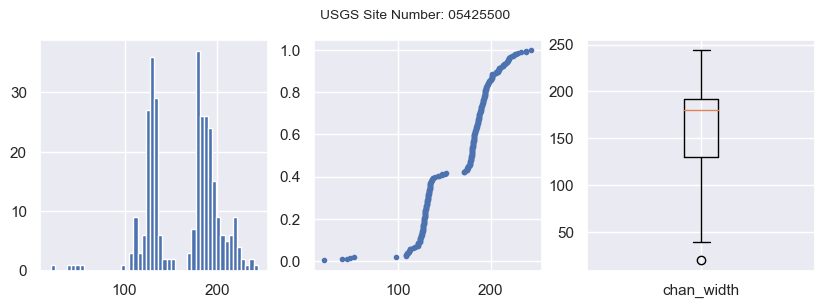

C:\Users\SERFANI\AppData\Local\Temp\ipykernel_15488\2420920370.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['measurement_dt'] = pd.to_datetime(dataframe['measurement_dt']).dt.date


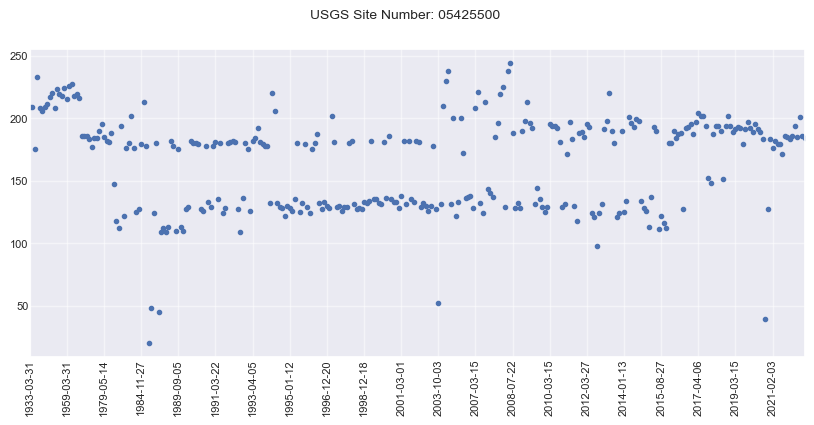

In [22]:
site_no='05425500'
site = site_extraction(site_no, save_csv=True)
stat_plot(site, site_no, 'chan_width', save_png=False)
plot_site_records(site, site_no, 'chan_width', save_png=False)

### Evaluation of Channel Width Variations WRT. Different Locations

In [324]:
site['channel_name'] = np.nan

C:\Users\SERFANI\AppData\Local\Temp\ipykernel_14032\2093499294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site['channel_name'] = np.nan


In [15]:
site['chan_name'].value_counts()

Imported Channel 1                              212
Main                                             35
main                                             25
1                                                24
rock river watertown                              2
Rock River at Watertown                           1
20101217 Rock River @ Watertown                   1
Rock River @ Warertown                            1
20110331watertown                                 1
Rock R. @ Watertown WI                            1
Main flow channel                                 1
2010-07-28                                        1
channel 1                                         1
Channel 1                                         1
MAIN                                              1
LEW to 1st Bridge Pier                            1
Rock at Watertown                                 1
rock                                              1
Rock River RiverRay From US Bridge                1
rock river a

In [339]:
# `chan`, `geo`, `gss001-009`
for index, row in site.iterrows():
    if '009' in row['chan_name'].lower():
        site.loc[index, 'channel_name'] = 'Channel 3'

In [348]:
wdth_dict = dict()
for name, group in site.groupby('channel_name'):
    wdth_dict[name] = group['chan_width'].to_numpy()

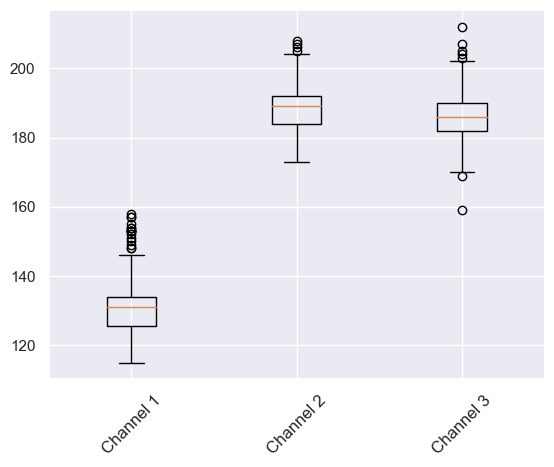

In [352]:
data = [val for val in wdth_dict.values()]

fig, ax = plt.subplots()
ax.boxplot(data)

ax.set_xticklabels([key for key in wdth_dict.keys()])
ax.tick_params(axis='x', labelrotation=45, labelsize=12)

ax.grid(True)
plt.show()

In [ ]:
data = [df["Left_BL"], df["Right_BL"], df["Aava"], df2["SOFI"]]

fig, ax = plt.subplots()
ax.boxplot(data)

ax.set_xticklabels(['Cam-L-BL', 'Cam-R-BL', 'Ultrasonic', 'SOFI'])
ax.tick_params(axis='x', labelrotation=45, labelsize=12)

ax.grid(True)
plt.show()

#### Using ML Techniques for Clustering Width Data

In [17]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

##### KMeans

In [152]:
k_means = KMeans(init="k-means++", n_clusters=2, n_init=20)
k_means.fit(site['chan_width'].to_numpy().reshape(-1, 1))

C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=2, n_init=20)

C:\Users\SERFANI\AppData\Local\Temp\ipykernel_14032\954607565.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['measurement_dt'] = pd.to_datetime(dataframe['measurement_dt']).dt.date


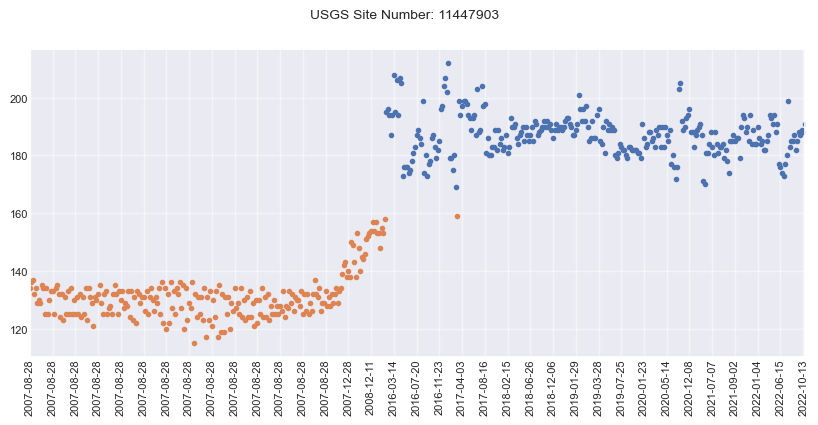

In [178]:
plot_site_clusters(site, k_means.labels_, site_no, 'chan_width', save_png=True)

##### DBSCAN

In [18]:
db = DBSCAN(eps=5, min_samples=20).fit(site['chan_width'].to_numpy().reshape(-1, 1))
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
print(n_clusters_)

2


C:\Users\SERFANI\AppData\Local\Temp\ipykernel_15488\2420920370.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['measurement_dt'] = pd.to_datetime(dataframe['measurement_dt']).dt.date


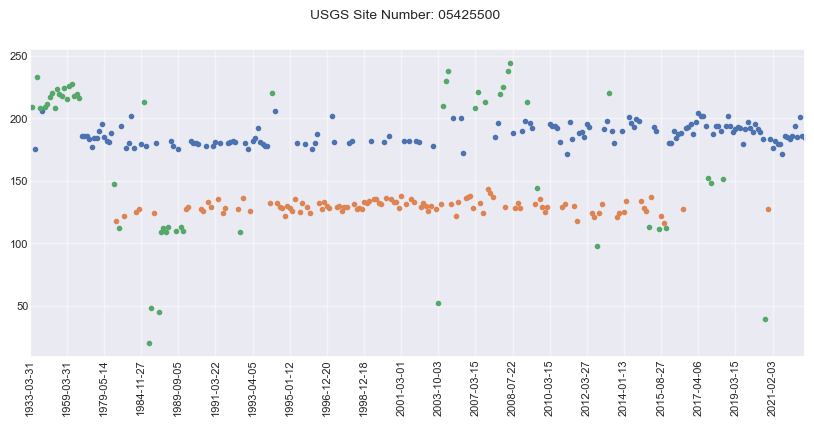

In [19]:
plot_site_clusters(site, db.labels_, site_no, 'chan_width', save_png=False)

#####  Hierarchical Clustering

In [234]:
hc = AgglomerativeClustering(linkage='average', n_clusters=3) # "ward", "average", "complete", "single"
hc.fit(site['chan_width'].to_numpy().reshape(-1, 1))

AgglomerativeClustering(linkage='average', n_clusters=3)

C:\Users\SERFANI\AppData\Local\Temp\ipykernel_14032\954607565.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['measurement_dt'] = pd.to_datetime(dataframe['measurement_dt']).dt.date


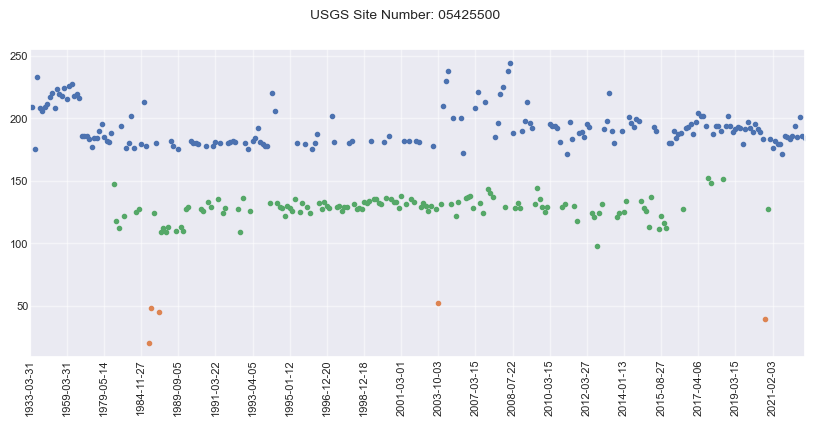

In [235]:
plot_site_clusters(site, hc.labels_, site_no, 'chan_width', save_png=True)